# TED – Word Clouds

![](img/ted_shaped_word_cloud_500.png)

## Introduction
This notebook goes through process of creating word clouds.

Specifically, we'll be walking through:

1. **Cleaning the data** - with popular text pre-processing techniques using spaCy
2. **Organizing the data** - organize the cleaned data into corpora and a document-term matrix
3. **Creating word clouds** – we'll find the most common words from different parts of speech and visualize them

Since using the entire dataset would require high-computation, I'll be reducing the scope to these three topics: `sex`, `religion`, `politics`.

In [54]:
import pickle
import re
import string
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import spacy
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

%matplotlib inline

## Data Cleaning

In [2]:
# load CSV and construct DataFrame
df = pd.read_csv('./data/ted_talks_en.csv')

print(f'Shape: {df.shape}')

Shape: (4005, 19)


For this exercise, we'll only need `talk_id`, `transcript`, `topics` columns.

In [3]:
df = df.loc[:, ['talk_id', 'topics', 'transcript']]
df.head()

,talk_id,topics,transcript
0,1,"['alternative energy', 'cars', 'climate change...","Thank you so much, Chris. And it's truly a gre..."
1,92,"['Africa', 'Asia', 'Google', 'demo', 'economic...","About 10 years ago, I took on the task to teac..."
2,7,"['computers', 'entertainment', 'interface desi...","(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,53,"['MacArthur grant', 'activism', 'business', 'c...",If you're here today — and I'm very happy that...
4,66,"['children', 'creativity', 'culture', 'dance',...",Good morning. How are you? (Audience) Good. It...


To reduce the scope, let's filter for talks about `sex`, `religion`, `politics` to improve performance. Feel free to do the same for a topic of your choice.

In [4]:
def find_topic(topic):
    """Returns a list of booleans for talks that contain a topic by index.
    
    :param topic: Topics or related topics of a talk
    """
    has_topic = []
    for t_list in df['topics']:
        if topic.lower() in pd.eval(t_list):
            has_topic.append(1)
        else:
            has_topic.append(0)
    return has_topic

In [5]:
# add columns for selected topics
df['is_sex'] = find_topic('sex')
df['is_religion'] = find_topic('religion')
df['is_politics'] = find_topic('politics')
df.head()

,talk_id,topics,transcript,is_sex,is_religion,is_politics
0,1,"['alternative energy', 'cars', 'climate change...","Thank you so much, Chris. And it's truly a gre...",0,0,0
1,92,"['Africa', 'Asia', 'Google', 'demo', 'economic...","About 10 years ago, I took on the task to teac...",0,0,0
2,7,"['computers', 'entertainment', 'interface desi...","(Music: ""The Sound of Silence,"" Simon & Garfun...",0,0,0
3,53,"['MacArthur grant', 'activism', 'business', 'c...",If you're here today — and I'm very happy that...,0,0,1
4,66,"['children', 'creativity', 'culture', 'dance',...",Good morning. How are you? (Audience) Good. It...,0,0,0


Using the new columns we created, we can now filter our DataFrame by these topics and create new DataFrames.

In [6]:
# filter DataFrame to only include talks about sex, religion, and politics
df = df.loc[(df['is_sex']==1) | (df['is_religion']==1) | 
            (df['is_politics']==1), : ].reset_index(drop=True)

# create new DataFrames for each topic (for later use)
sex_df = df.loc[(df['is_sex']==1), 'talk_id':'transcript'].reset_index(drop=True)
religion_df = df.loc[(df['is_religion']==1), 'talk_id':'transcript'].reset_index(drop=True)
politics_df = df.loc[(df['is_politics']==1), 'talk_id':'transcript'].reset_index(drop=True)

print('Sex', sex_df.shape)
print('Religion', religion_df.shape)
print('Politics', politics_df.shape)

Sex (57, 3)
Religion (87, 3)
Politics (210, 3)


### All talks DataFrame
With our topic-specific DataFrames created, we can now consruct a `3x1 DataFrame` with all talks for each topic for analyzing most common words.

In [7]:
def combine_transcripts(transcript_list):
    """Input a list of transcripts and return them as a corpus.
    :param list_of_text: Transcript list"""
    corpus = ' '.join(transcript_list)
    return corpus

In [8]:
def transcripts_to_dict(df, topic_list):
    """Returns a dictionary of transcripts for each topic.
    
    :param df: DataFrame
    :param topic_list: List of topics
    """
    ted_dict = {}

    for topic in topic_list:
        # filter DataFrame to specific series and convert it to a list
        filter_string = 'is_' + str(topic)
        text_list = df.loc[(df[filter_string]==1), 'transcript'].to_list()

        # call combine_transcripts function to return combined text
        combined_text = combine_transcripts(text_list)

        # add combined text to dict
        ted_dict[topic] = combined_text
    return ted_dict

In [9]:
# create dictionary from the DataFrame
transcript_dict = transcripts_to_dict(df, ['sex', 'religion', 'politics'])

# construct DataFrame from dictionary
df = pd.DataFrame.from_dict(transcript_dict, orient='index')
df.rename({0: 'transcript'}, axis=1, inplace=True)

In [10]:
df.head()

,transcript
sex,"Being a child, and sort of crawling around the..."
religion,"On September 10, the morning of my seventh bir..."
politics,If you're here today — and I'm very happy that...


Our DataFrame `df` now has 3 rows where each value contains all the transcripts combined for the respective topic.

## Clean text

We're now ready to do some text pre-processing. This cleaning process can go on forever, but we'll be doing the following:

**First cleaning step:**
* Remove text in square brackets & parenthesis
* Remove punctuation
* Remove numerical values
* Remove stop words
* Tokenize text

**Cleaning after tokenization:**
* Stemming / lemmatization
* Parts of speech tagging

The result will be two corpora:
* all text – contains all parts of speech
* nouns and adjectives

We could also include **verbs** or even **named entities**, but I've chosen to show **all text** and **nouns/adjectives** to keep things simple (and not have you scroll endlessly).

In [11]:
def clean_text(text):
    """Returns clean text.
    Removes:
        *text in square brackets & parenthesis
        *punctuation
        *words containing numbers
        *double-quotes, dashes
    """
#     text = text.lower()
    text = re.sub('[\[\(].*?[\)\]]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[\“\–]', '', text)
    return text

In [12]:
# clean text
df['transcript'] = pd.DataFrame(df['transcript'].apply(lambda x: clean_text(x)))
sex_df['transcript'] = pd.DataFrame(sex_df['transcript'].apply(lambda x: clean_text(x)))
religion_df['transcript'] = pd.DataFrame(religion_df['transcript'].apply(lambda x: clean_text(x)))
politics_df['transcript'] = pd.DataFrame(politics_df['transcript'].apply(lambda x: clean_text(x)))

In [13]:
# pickle DataFrame (checkpoint)
df.to_pickle('data/sex_religion_politics_corpus.pkl')
sex_df.to_pickle('data/sex_corpus.pkl')
religion_df.to_pickle('data/religion_corpus.pkl')
politics_df.to_pickle('data/politics_corpus.pkl')

## Corpora

We'll be using spaCy for natural language processing.  

If you're interested in other languages, you can checkout the latest available models from [spaCy](https://spacy.io/usage/models).

In [14]:
# load SpaCy English model
nlp = spacy.load('en_core_web_sm')

# transform DataFrames to list of docs (corpus)
all_srp_texts = df.loc[:, 'transcript'].to_list()
sex_texts = sex_df.loc[:, 'transcript'].to_list()
religion_texts = religion_df.loc[:, 'transcript'].to_list()
politics_texts = politics_df.loc[:, 'transcript'].to_list()

# process each corpus
all_srp_docs = list(nlp.pipe(all_srp_texts))
sex_docs = list(nlp.pipe(sex_texts))
religion_docs = list(nlp.pipe(religion_texts))
politics_docs = list(nlp.pipe(politics_texts))

Let's take a look at the sex corpus (part of it at least).

In [15]:
# print first 1000 characters
sex_docs[0].text[:1000]

'Being a child and sort of crawling around the house I remember these Turkish carpets and there were these scenes these battle scenes these love scenes I mean look this animal is trying to fight back this spear from this soldier And my mom took these pictures actually last week of our carpets and I remember this to this day There was another object this sort of towering piece of furniture with creatures and gargoyles and nudity — pretty scary stuff when youre a little kid What I remember today from this is that objects tell stories so storytelling has been a really strong influence in my work And then there was another influence I was a teenager and at  or  I guess like all teenagers we want to just do what we love and what we believe in And so I fused together the two things I loved the most which was skiing and windsurfing Those are pretty good escapes from the drab weather in Switzerland So I created this compilation of the two I took my skis and I took a board and I put a mast foot

### Corpus: All text

Now that we have a corpus, let's lemmatize it and only keep alphanumeric characters without stop words.

In [16]:
def get_all_text(spaCy_doc, topics):
    """Returns a dictionary of lemmatized text.
    Keeps alphanumeric characters and non stop words.

    :param spaCy_doc: spaCy Doc object (corpus) and topic list
    """
    my_dict = {}
    for ix, doc in enumerate(spaCy_doc):
        tag = topics[ix]
        token_list = []
        for token in doc:
            if (token.is_alpha==1) & (token.is_stop==0):
                token_list.append((token.lemma_).lower())
        my_dict[tag] = ' '.join(token_list)
    return my_dict

In [17]:
# create dictionary of transcripts with all text
all_srp_text_dict = get_all_text(all_srp_docs, ['sex', 'religion', 'politics'])

In [18]:
# construct DataFrame
all_srp_text_df = pd.DataFrame.from_dict(all_srp_text_dict, orient='index')
all_srp_text_df.rename({0: 'transcript'}, axis=1, inplace=True)
all_srp_text_df.head()

,transcript
sex,child sort crawl house remember turkish carpet...
religion,september morning seventh birthday come downst...
politics,today be happy have hear sustainable developme...


In [19]:
# pickle DataFrame for later use
all_srp_text_df.to_pickle('data/all_srp_text_df.pkl')

### Corpus: *Nouns & adjectives*

Now we'll be doing a similar process as above, but only keeping `nouns & adjectives`.

In [20]:
def get_nouns_adj(spaCy_doc, topic_list):
    """
    Input a spaCy Doc object (corpus) and topic list.
    Return a dictionary of lemmatized nouns and adjectives per doc.
    Keep alphanumeric characters and non stop words.
    """
    topics = topic_list
    my_dict = {}
    for ix, doc in enumerate(spaCy_doc):
        topic = topics[ix]
        token_list = []
        for token in doc:
            if (token.is_alpha==1) & (token.is_stop==0) & (token.pos_ in ['NOUN', 'ADJ']):
                token_list.append((token.lemma_).lower())
        my_dict[topic] = ' '.join(token_list)
    return my_dict

In [21]:
# create dictionary of transcripts with nouns and adjectives
all_srp_nouns_adj_dict = get_nouns_adj(all_srp_docs, ['sex', 'religion', 'politics'])

In [22]:
# construct DataFrame
all_srp_nouns_adj_df = pd.DataFrame.from_dict(all_srp_nouns_adj_dict, orient='index')
all_srp_nouns_adj_df.rename({0: 'transcript'}, axis=1, inplace=True)

In [23]:
all_srp_nouns_adj_df

,transcript
sex,child house turkish carpet scene battle scene ...
religion,morning seventh birthday kitchen mother dish f...
politics,today happy sustainable development real susta...


In [24]:
# pickle DataFrame for later use
all_srp_nouns_adj_df.to_pickle('data/all_srp_nouns_adj_df.pkl')

## Document-Term Matrices

To create our document-term matrices, we'll be using Scikit-Learn's CountVectorizer, where every row will represent a different document and every column will represent a different word.

In addition, with CountVectorizer, we can remove stop words.

### Stop words

In [25]:
def get_stop_words(spaCy_doc_obj):
    """Returns a list of stop words from doc object.
    
    :param spaCy_doc_obj: spacy.tokens.doc.Doc object
    """
    stop_words = []
    for doc in spaCy_doc_obj:
        for token in doc:
            if token.is_stop:
                stop_words.append(token.text.lower())
    return set(stop_words)

In [26]:
# initial stop word list
stop_words_spacy = list(get_stop_words(all_srp_docs))

# pickle for later use
with open('data/stop_words_spacy.pkl', 'wb') as f:
    pickle.dump(stop_words_spacy, f)
    f.close()

In [27]:
def create_document_term_matrix(df):
    """Input a DataFrame and return a document-term matrix with initial stop words"""
    cv = CountVectorizer(stop_words=stop_words_spacy)
    data_cv = cv.fit_transform(df['transcript'])
    dtm_df = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    dtm_df.index = df.index
    return dtm_df

In [28]:
# create document-term matrices for corpora
all_srp_all_text_dtm = create_document_term_matrix(all_srp_text_df)
all_srp_nouns_adj_dtm = create_document_term_matrix(all_srp_nouns_adj_df)

/Users/miguel/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [29]:
# pickle document-term matrices (for later use)
all_srp_all_text_dtm.to_pickle('data/all_srp_all_text_dtm.pkl')
all_srp_nouns_adj_dtm.to_pickle('data/all_srp_nouns_adj_dtm.pkl')

# Word Clouds

## Word Cloud – All Text

We could create word clouds from this point, but we'll be updating the stop words to remove words that add little value including those that are commonly used in all three topics `sex`, `religion`, `politics`.

### Update stop words

In [30]:
# load pickled document-term matrix
all_srp_all_text_dtm = pd.read_pickle('data/all_srp_all_text_dtm.pkl')

# transpose document-term matrix
all_srp_all_text_dtm_transposed = all_srp_all_text_dtm.transpose()

In [31]:
# find the top words said by each topic
n_words = 10
top_dict = {}
for topic in all_srp_all_text_dtm_transposed.columns:
    top = all_srp_all_text_dtm_transposed[topic].sort_values(ascending=False).head(n_words)
    top_dict[topic]= list(zip(top.index, top.values))
    
# print the top words said by each topic
for topic, top_words in top_dict.items():
    print(topic)
    print(', '.join([word for word, count in top_words[0:n_words]]))
    print('---')

sex
like, sex, know, think, woman, people, want, thing, right, look
---
religion
people, think, like, know, world, thing, god, come, way, time
---
politics
people, think, world, like, know, year, thing, country, want, come
---


In [32]:
# look at the most common top words --> add them to the stop word list

# let's first pull out the top words for each topic
words = []
for topic in all_srp_all_text_dtm_transposed.columns:
    top = [word for (word, count) in top_dict[topic]]
    for t in top:
        words.append(t)

In [33]:
# let's aggregate this list and identify the most common words
print(Counter(words).most_common())

[('like', 3), ('know', 3), ('think', 3), ('people', 3), ('thing', 3), ('want', 2), ('world', 2), ('come', 2), ('sex', 1), ('woman', 1), ('right', 1), ('look', 1), ('god', 1), ('way', 1), ('time', 1), ('year', 1), ('country', 1)]


In [34]:
# if all three topics have the top word, exclude it
add_stop_words = [word for word, count in Counter(words).most_common() if count >= 3]
add_stop_words

['like', 'know', 'think', 'people', 'thing']

In [35]:
# add custom stop words
custom_stop_words = [
#     'sex',
    'world',
#     'religion',
#     'god',
#     'religious',
#     'political',
#     'not',
    'know',
    'thing',
    'know',
    'think',
    'come',
#     'people'
]

In [36]:
# load initial stop words
with open('data/stop_words_spacy.pkl', 'rb') as f:
    initial_stop_words = list(pickle.load(f))
    f.close()

In [37]:
def update_stop_words(list_to_update, add_stop_words, custom_stop_words):
    """Add custom stop words to stop word list"""
    stop_words = list_to_update
    for word in add_stop_words:
        stop_words.append(word)
    for word in custom_stop_words:
        stop_words.append(word)
    return stop_words

In [38]:
# add new stop words
stop_words_curated = update_stop_words(initial_stop_words, add_stop_words, custom_stop_words)

### Update document-term matrix

Let's update our document-term matrix with the new list of stop words

In [39]:
# recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words_curated)

# load DataFrame
all_srp_text_df = pd.read_pickle('data/all_srp_text_df.pkl')

# count vectorize the DataFrame
data_cv = cv.fit_transform(all_srp_text_df['transcript'])

# construct new DataFrame
all_srp_text_dtm_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
all_srp_text_dtm_stop.index = all_srp_text_df.index

/Users/miguel/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Word clouds

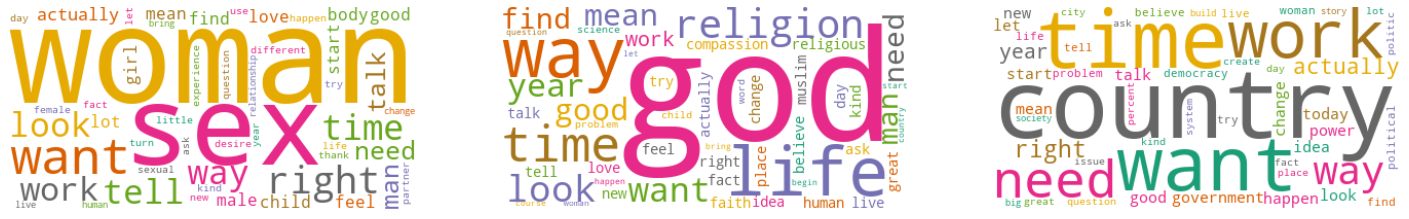

In [40]:
word_cloud = WordCloud(stopwords=stop_words_curated, background_color='white', colormap='Dark2',
                       max_font_size=150, random_state=2020, max_words=50)

plt.rcParams['figure.figsize'] = [25, 10]

topics = ['sex', 'religion', 'politics']

# create subplots for each topic
for index, topic in enumerate(all_srp_all_text_dtm_transposed.columns):
    word_cloud.generate(all_srp_text_df.transcript[topic])
    
    plt.subplot(1, 3, index+1)
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
#     plt.title(topics[index])
    
plt.show()

## Word Cloud – Nouns and Adjectives

### Update stop words

In [41]:
# load pickled document-term matrix
all_srp_nouns_adj_dtm = pd.read_pickle('data/all_srp_nouns_adj_dtm.pkl')

# transpose document-term matrix
all_srp_nouns_adj_dtm_transposed = all_srp_nouns_adj_dtm.transpose()

In [42]:
# find the top words said by each topic
n_words = 10
top_dict = {}
for topic in all_srp_nouns_adj_dtm_transposed.columns:
    top = all_srp_nouns_adj_dtm_transposed[topic].sort_values(ascending=False).head(n_words)
    top_dict[topic]= list(zip(top.index, top.values))
    
# print the top words said by each topic
for topic, top_words in top_dict.items():
    print(topic)
    print(', '.join([word for word, count in top_words[0:n_words]]))
    print('---')

sex
sex, woman, people, thing, time, man, sexual, way, male, body
---
religion
people, world, thing, time, way, life, religion, year, human, good
---
politics
people, world, year, thing, country, way, time, power, good, political
---


In [43]:
# look at the most common top words --> add them to the stop word list

# let's first pull out the top words for each topic
words = []
for topic in all_srp_nouns_adj_dtm_transposed.columns:
    top = [word for (word, count) in top_dict[topic]]
    for t in top:
        words.append(t)

In [44]:
# let's aggregate this list and identify the most common words
print(Counter(words).most_common())

[('people', 3), ('thing', 3), ('time', 3), ('way', 3), ('world', 2), ('year', 2), ('good', 2), ('sex', 1), ('woman', 1), ('man', 1), ('sexual', 1), ('male', 1), ('body', 1), ('life', 1), ('religion', 1), ('human', 1), ('country', 1), ('power', 1), ('political', 1)]


In [45]:
# if all three topics have the top word, exclude it
add_stop_words = [word for word, count in Counter(words).most_common() if count >= 3]
add_stop_words

['people', 'thing', 'time', 'way']

In [46]:
# Add custom stop words
custom_stop_words = [
#     'sex',
    'world',
#     'religion',
#     'god',
#     'religious',
#     'political',
#     'not',
#     'know',
#     'thing',
#     'know',
#     'think',
#     'come',
#     'people'
]

In [47]:
# load initial stop words
with open('data/stop_words_spacy.pkl', 'rb') as f:
    initial_stop_words = list(pickle.load(f))
    f.close()

In [48]:
def update_stop_words(list_to_update, add_stop_words, custom_stop_words):
    """Add custom stop words to stop word list"""
    stop_words = list_to_update
    for word in add_stop_words:
        stop_words.append(word)
    for word in custom_stop_words:
        stop_words.append(word)
    return stop_words

In [49]:
# add new stop words
stop_words_curated = update_stop_words(initial_stop_words, add_stop_words, custom_stop_words)

### Update document-term matrix

Let's update our document-term matrix with the new list of stop words

In [50]:
# recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words_curated)

# load DataFrame
all_srp_nouns_adj_df = pd.read_pickle('data/all_srp_nouns_adj_df.pkl')

# count vectorize the DataFrame
data_cv = cv.fit_transform(all_srp_nouns_adj_df['transcript'])

# construct new DataFrame
all_srp_nouns_adj_dtm_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
all_srp_nouns_adj_dtm_stop.index = all_srp_nouns_adj_df.index

/Users/miguel/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Word clouds

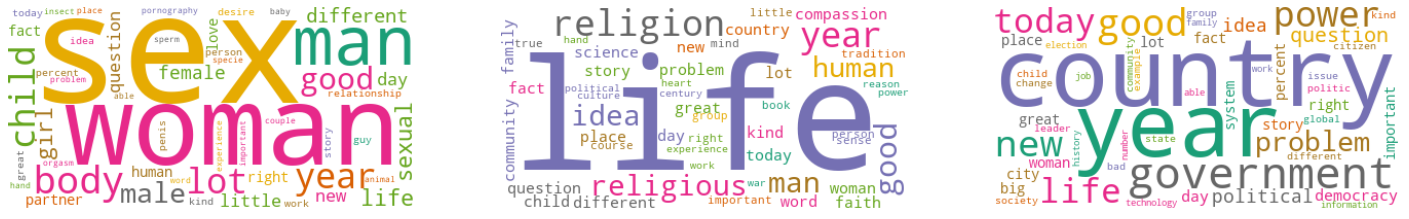

In [51]:
word_cloud = WordCloud(stopwords=stop_words_curated, background_color='white', colormap='Dark2',
                       max_font_size=150, random_state=2020, max_words=50)

plt.rcParams['figure.figsize'] = [25, 10]

topics = ['sex', 'religion', 'politics']

# create subplots for each topic
for index, topic in enumerate(all_srp_nouns_adj_dtm_transposed.columns):
    word_cloud.generate(all_srp_nouns_adj_df.transcript[topic])
    
    plt.subplot(1, 3, index+1)
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
#     plt.title(topics[index])
    
plt.show()

## TED Shape

Let's have a little fun and create a shape for our wordcloud.

In [72]:
ted_mask = np.array(Image.open("img/ted_mask.png"))

In [105]:
ted_df = all_srp_nouns_adj_df.copy()

In [106]:
all_transcripts = (ted_df.loc['sex', 'transcript']+ ted_df.loc['religion', 'transcript'] 
                   + ted_df.loc['politics', 'transcript'])

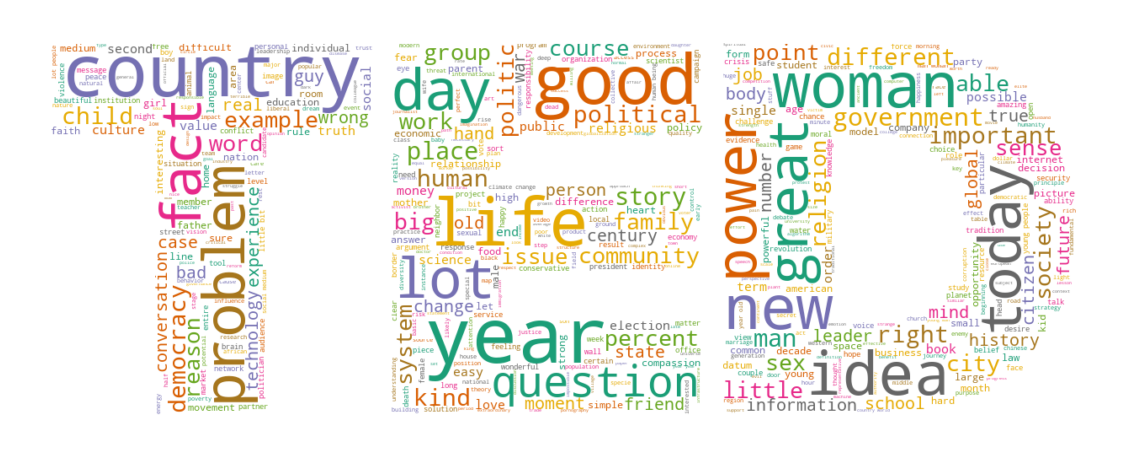

In [113]:
# create a word cloud image
wc = WordCloud(background_color="white", mask=ted_mask, max_words=500,
               stopwords=stop_words_curated, contour_width=3, 
               colormap='Dark2', contour_color='white')

# generate a wordcloud
wc.generate(all_transcripts)

# store to file
wc.to_file("img/ted_shaped_word_cloud.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

I hope you enjoyed going through this notebook! If you have any questions, please feel free to comment.

If you'd like to learn more about creating word clouds, please check out [DataCamp's tutorial](https://www.datacamp.com/community/tutorials/wordcloud-python).